In [89]:

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from threading import Thread


## Group Assignment
### Team Number: 7
### Team Member Names: Alex Xue, Rahman Merchant, Medhansh Agrawal
### Team Strategy Chosen: SAFE

## Overview
We have chosen safe to be our team's strategy. Our goal is to create a portfilio that generates at little fluctuations as possible.

This document consist 4 main parts:
1. Filter out all stocks that do not satisfy the assignment requirement
2. Choose 25 stocks from the remaining by analyzing historical volatility, beta, and implied volatility
3. Perform Monte Carlo simulation to decide the weighting every stocks
4. Output a corresponding stock portfilio

## Our Strategy


### Efficient Markets Hypothesis (EMH)
Efficient Markets Hypothesis states in an efficient market, stock price at any given time will reflect all available information given. Stock price will adjust to a new information instantaneously. According to this theory, stock price is unpredictable. Thus, the best method to predict a stock price is to conduct a random walk simulation based on current stock price (Markov property).

### Choose stock using historical AND implied volatility
In CFM classes, we learned about how to calculate stocks' historical volatility and beta. However, EMH tells us future stock performance is independent of  historical performance. We partically agree to this because many stocks and funds (with good sharp ratio) that performed well often did not continue to performance as good as before. Therefore, we believe we can't only look at historical stock volatility to decide how risky a stock will be. Instead, while we still take historical volatility and beta into consideration, we also look at the implied volatility of a stock. Implied volatility of a stock is derived from Black Scholes model (a model for option pricing). Implied volatility describes what investors believe future stocks' volatility will be based on the price of a given option. Taking implied volatility along with historical volatility and beta values can provide us a more comprehensive understanding about how risky a stock is.

(This is just a brief summary. We will explain this in much more detail latter when we calculate implied volatility)

### Perform Monte Carlo simulation
Random Walk Hypothesis believes stock prices will always perform a Brownian motion only based on current stock price. Historical stock price does not affect future prices. Hence, future stock price is unpredictable and any attempts to predict future stock price will be worthless. The Random Walk Hypothesis echos with the boarder Efficient Markets Hypothesis. In fact, a random walk simulation is exactly what we will do to decide the weighting given to every 25 stock in our portfolio. In this assignment, we will use Geometric Brownian motion, a version of random walk, to estimate the future stock price.
(This is just a brief summary. -We will explain this in much more detail latter when we perform Monte Carlo Simulation)


## Use of OOP

We have decided to use OOP in this assignment based on following considerations:

1. Optimize Running Efficiency
We recognize executing code that calls Yahoo Finance library is relatively slow. While we tried to solve this problem by using multi-threading, we also uses caching. We decided to create a class called 'StockAnalytics'. We will instantiate a StockAnalytics class for every ticker given in Ticker.csv file. Instead of calling methods like yf.Ticker() or stock.info() or stock.history(), we have created methods in StockAnalytics class get_ticker(), get_info(), and get_history_info(). For the first time these methods are called, it will still call the Yahoo Finance library to give you the result, but also cache the result as a field in the instance. By doing so, if we need to call say get_info() or get_history_info() for another time, the code will directly return the data store in the field of the instance, instead of calling the Yahoo Finance library for another time. Introducing OOP provides a good way for us to cache Yahoo Finance data, and minimize number of calls to the Yahoo Finance library.


2. Improve Code Adaptability
While our code meets the requirement for this assignment, using OOP allows us to adapt our code easily if for some reason the requirement for this assignment changes. For example, if we need to do this assignment a year later, we can quickly adapt a new version of our code by just changing some input arguments for methods inside Stock and StockAnalytics.

3. Improve Code Reuseability
In our code, we create classes like Stock and StockAnalytics. We believe these objects can not only be used for this assignment, but also any future stock data analysis assignments as well. We can just import the Stock and StockAnalytics modules for this assignment to future projects. For example, if we would like to calculate the beta for a stock for any given period, at any market, we can use methods from StockAnalytics class. We believe this will significantly  improve code reuseability and prevent writing repetitive code for any future projects.

We decided to create a general class Stock that gives some general info about a stock, and class StockAnalytics which inherits from class Stock but provide more stock analysis methods like get_historical_beta() and get_weighted_implied_volatility(). The reason for doing this is to follow the Open-closed principle for Object Oriented Design-- Objects should be open for extension but closed for modification. We want Stock to be a simple object that anyone can use in stock analysis and easily make extension to Stock without changing the content of class Stock.

In [90]:
class Stock:
    """
    A general class stock that provides basic data such as the ticker, historical data, and info from Yahoo Finance
    """
    # Constructor function
    def __init__(self, ticker):
        self.ticker = ticker;
        self.yf = yf.Ticker(ticker);
        self.info = '';
        self._history_info = {};

    # toString function
    def __str__(self):
        return self.ticker;

        # Get stock ticker
    def get_ticker(self):
        return self.ticker;

    # Get stock info
    def get_info(self):
        # Check is stock_info is cached
        # Stock info is not cached if it is a string type
        if isinstance(self.info, str):
            return self.yf.info;
        return self.info

    # Cache other historical data into a dictionary
    def get_history_info(self, start='2016-01-01', end='2022-11-01', interval='1d'):
        # Check the input args type
        try:
            assert isinstance(start, str);
            assert isinstance(end, str);
            assert isinstance(end, str);
        except Exception :
            print("At least one input have incorrect data type. Required Args: Str Str Str");
            print(Exception.__class__, "occurred.\n");

        # Generate a key value to cache a stock's historical data into a dictionary
        key = start+end+interval;

        # If that key value has already been cached, directly return value
        if key in self._history_info:
            return self._history_info[key];
        else:
            # Calculate the historical data and cache it into the dictionary
            self._history_info[key] = self.yf.history(start=start, end=end, interval=interval);
            return self._history_info[key];


In [91]:
class StockAnalytics(Stock):
    """
    StockAnalytics is an extension of Stock. It provides more methods for stock data analysis such as historical return,
    implied volatility, and beta. In this assignment, we will always use StockAnalytics (instead of using Stock)
    """

    # Constructor function
    def __init__(self, ticker):
        Stock.__init__(self,ticker);
        self._historical_volatility = {};
        self._historical_return = {};
        self._historical_beta = {};
        self._weighted_implied_volatility = '';

    # toString function
    def __str__(self):
        return self.ticker;

    # Get historical return based on given start, end, and interval arguments
    def get_historical_return(self, start='2016-01-01', end='2022-11-01', interval='1d'):
        # Check the input args type
        try:
            assert isinstance(start, str);
            assert isinstance(end, str);
            assert isinstance(interval, str);
        except Exception :
            print("At least one input have incorrect data type. Required Args: Str Str Str");
            print(Exception.__class__, "occurred.\n");

        # Check if historical return is already cached
        key = start+end+interval;

        # If cached, directly return the result
        if key in self._history_info:
            return self._historical_return[key];

        try:
            # Get the historical data based on input arguments
            stock_hist = self.get_history_info(start=start, end=end, interval=interval);

            # Get the historical closing price
            prices = pd.DataFrame(stock_hist['Close']);

            # Calculate the percentage change of daily closing stock price
            daily_returns = prices.pct_change();

            # Filter out all nan values
            daily_returns = daily_returns.dropna();

            # Cache data
            self._historical_return[key] = daily_returns;

            return daily_returns
        except Exception:
            print('error: Historical return of ' + self.ticker + ' cannot be fetched');
            print(Exception.__class__, "occurred.\n");

    # Get historical volatility (annual) based on given start, end, and interval arguments
    def get_historical_volatility(self, start='2016-01-01', end='2022-11-01', interval='1d'):
        # Check the input args type
        try:
            assert isinstance(start, str);
            assert isinstance(end, str);
            assert isinstance(end, str);
        except Exception :
            print("At least one input have incorrect data type. Required Args: Str Str Str");
            print(Exception.__class__, "occurred.\n");

        key = start+end+interval
        # Directly return cached value if data is already cached
        if key in self._historical_volatility:
            return self._historical_volatility[key];
        else:
            # Get historical return based on args
            historical_return = self.get_historical_return(start, end, interval);

            # Calculate daily volatility and stored it as a list
            historical_daily_volatility = historical_return.std().tolist()[0]

            # Calculate annual volatility from daily volatility (assume 250 trading days per year)
            historical_annual_volatility = historical_daily_volatility * (250 ** 0.5);

            # Round to 4 decimal places
            historical_annual_volatility = np.round(historical_annual_volatility, 4);

            # Cache annual volatility into dictionary
            self._historical_volatility[key] = historical_annual_volatility;

        return historical_annual_volatility;

    # Get historical beta of a stock based on market index, start date, end date, and interval
    def get_historical_beta(self, market_index, start='2016-01-01', end='2022-11-01', interval='1d'):
        # Check the input args type
        try:
            assert isinstance(market_index, (Stock, StockAnalytics));
            assert isinstance(start, str);
            assert isinstance(end, str);
            assert isinstance(interval, str);
        except Exception :
            print("At least one input have incorrect data type. Required Args: Stock Str Str Str");
            print(Exception.__class__, "occurred.\n");

        # Generate a key value to cache a stock's historical data into a dictionary
        key = market_index.get_ticker() + start+end+interval;

        # If that key value has already been cached, directly return value
        if key in self._historical_beta:
            return self._historical_beta[key];

        # Get historical market return and variance
        historical_market_return = market_index.get_historical_return(start, end, interval);
        historical_stock_return = self.get_historical_return(start, end, interval);
        historical_market_var = historical_market_return['Close'].var();
        historical_market_return['Stock'] = historical_stock_return['Close'];


        # Filter nan in historical_market_return
        historical_market_return = historical_market_return[historical_market_return.notnull().all(1)]

        # Get beta value
        stock_historical_beta = np.cov(historical_market_return['Close'], historical_market_return['Stock']) / historical_market_var;
        stock_historical_beta = np.round(stock_historical_beta[0][1],4);

        # Cache beta value
        self._historical_beta[key] = stock_historical_beta;

        return stock_historical_beta;

    # Get weighted average of implied volatility
    def get_weighted_implied_volatility(self):
        """
        Calcuate the implied volatility of the stock in 1 year
        Implied volatility is obtained by calculating
        average of implied volatility from call options
        that will be matured in 1 year. The weight is determined
        by the trading volume of every call option
        :return:
        """
        # If that implied volatility has already been cached, directly return value
        if isinstance(self._weighted_implied_volatility, (float, int)):
            return self._weighted_implied_volatility;

        try:
            # Find options that will mature in about 1 yr
            for i in range((len(self.yf.options))):
                # It is hard to get options that will mature exactly in 1 yr
                # Therefore, we use the first round of maturing options in 2024
                # to estimate options maturing in 1 yr.
                if self.yf.options[i].startswith('2024'):
                    break;

            # Create a dataframe for call options maturing in early 2024
            option_info = self.yf.option_chain(self.yf.options[i]);
            option_info = pd.DataFrame().append(option_info.calls);

            # Get volume for each call options in option_info
            volume = option_info['volume'];
            volume.fillna(0, inplace=True);

            # Calculate weighted implied volatility by trading volume
            weighted_implied_volatility = np.average(option_info['impliedVolatility'], weights=option_info['volume']);
            weighted_implied_volatility = np.round(weighted_implied_volatility,4);

            # Cache implied volatility
            self._weighted_implied_volatility = weighted_implied_volatility;
            return weighted_implied_volatility;

        except Exception:
            print('Error:' + self.ticker + ' info cannot be obtained');
            print(Exception);

    # Plot market benchmark return v.s stock return
    def get_beta_scatter_plot(self, market_index, start='2016-01-01', end='2022-11-01', interval='1d'):
        # Check the input args type
        try:
            assert isinstance(market_index, Stock);
            assert isinstance(start, str);
            assert isinstance(end, str);
            assert isinstance(interval, str);
        except Exception :
            print("At least one input have incorrect data type. Required Args: Stock Str Str Str");
            print(Exception.__class__, "occurred.\n");

        # Get historical market return and variance
        historical_market_return = market_index.get_historical_return(start, end, interval);
        historical_stock_return = self.get_historical_return(start, end, interval);
        historical_market_return['Stock'] = historical_stock_return['Close'];

        # Filter nan in historical_market_return
        historical_market_return = historical_market_return[historical_market_return.notnull().all(1)]

        x = historical_market_return['Close'];
        y = historical_market_return['Stock']
        plt.figure(figsize=(6,4));
        plt.scatter(x, y , marker='o');
        plt.title(self.ticker + ' Return v.s. Market Return')
        plt.xlabel('Benchmark Returns');
        plt.ylabel(self.ticker + ' Return');
        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x+b, color='red', label = 'y = {:.2f} + {:.2f}*x'.format(b ,m));
        plt.legend(loc='lower right')
        plt.show();

    def plot_implied_volatility_distribution(self):
        try:
            # Find options that will mature in about 1 yr
            for i in range((len(self.yf.options))):
                # It is hard to get options that will mature exactly in 1 yr
                # Therefore, we use the first round of maturing options in 2024
                # to estimate options maturing in 1 yr.
                if self.yf.options[i].startswith('2024'):
                    break;

            # Create a dataframe for call options maturing in early 2024
            option_info = self.yf.option_chain(self.yf.options[i]);
            option_info = pd.DataFrame().append(option_info.calls);
            price = option_info['strike'];
            volatility = option_info['impliedVolatility'];
            volume = option_info['impliedVolatility'];
            volume.fillna(0, inplace=True)
            print(option_info)
            print(volatility)

            plt.plot(price, volatility)
            plt.show();


        except Exception:
            print('Failed to graph implied volatility distribution graph');
            print('Error:' + self.ticker + ' info cannot be obtained');
            print(Exception);

## Part 1: Filtering

In [95]:
# Convert list of stocks tickers into list of stocks:
def stock_ticker_to_stock_list(csv_file):
    list_of_stocks = [];
    for i in (range(len(csv_file))):
        list_of_stocks.append(StockAnalytics(csv_file[i]));
    return list_of_stocks;

In [97]:
# import stock list file
csv_file = pd.read_csv('Tickers.csv', header=None)[0].tolist();

# print fall stocks obtained from the csv file
print(csv_file);

# Convert all stocks in the csv_file into a list of StockAnalytics type
list_of_stocks = stock_ticker_to_stock_list(csv_file);

['AAPL', 'ABBV', 'ABT', 'ACN', 'AGN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CELG', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CSCO', 'CVS', 'GM', 'GOOG', 'JPM', 'KMI', 'KO', 'LLY', 'LMT', 'MO', 'MON', 'MRK', 'MS', 'MSFT', 'NEE', 'NKE', 'ORCL', 'OXY', 'PCLN', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RTN', 'RY.TO', 'SBUX', 'SLB', 'SO', 'SPG', 'T', 'TD.TO', 'TGT', 'TWX', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']


In [162]:
def filter_stocks_by_currency(list_of_stocks, currency='USD'):
    # Check the input args type
    try:
        assert isinstance(currency, str);
    except Exception :
        print("At least one input have incorrect data type.");
        print(Exception.__class__, "occurred.\n");

    filtered_stocks = []
    for i in range(len(list_of_stocks)):
        try:
            stock = list_of_stocks[i];
            stock_info = stock.get_info();
            stock_currency = stock_info['financialCurrency'];
            if stock_currency == currency:
                filtered_stocks.append(stock);
                print('[SUCCESS] ' + stock.get_ticker() + ' is added');
                continue;
            else:
                print('[WARNING] ' + stock.get_ticker() + ' is filtered because it is trading in ' +
                      stock_currency + '\n Requirement currency is ' + currency)
        except Exception as e:
            print('[MESSAGE]: Invalid name/delisted', csv_file[i]);
    return filtered_stocks;


In [163]:
# Filter out stocks not trading in the US and stocks delisted
currency_filtered_stock_list = filter_stocks_by_currency(list_of_stocks);

# Present the filtered stock list:
print('\n');
print('filtered stocks:')
for stock in currency_filtered_stock_list:
    print(stock);


[SUCCESS] AAPL is added
[SUCCESS] ABBV is added
[SUCCESS] ABT is added
[SUCCESS] ACN is added
[MESSAGE]: Invalid name/delisted AGN
[SUCCESS] AIG is added
[SUCCESS] AMZN is added
[SUCCESS] AXP is added
[SUCCESS] BA is added
[SUCCESS] BAC is added
[SUCCESS] BIIB is added
[SUCCESS] BK is added
[SUCCESS] BLK is added
[SUCCESS] BMY is added
[SUCCESS] C is added
[SUCCESS] CAT is added
[MESSAGE]: Invalid name/delisted CELG
[SUCCESS] CL is added
[SUCCESS] CMCSA is added
[SUCCESS] COF is added
[SUCCESS] COP is added
[SUCCESS] COST is added
[SUCCESS] CSCO is added
[SUCCESS] CVS is added
[SUCCESS] GM is added
[SUCCESS] GOOG is added
[SUCCESS] JPM is added
[SUCCESS] KMI is added
[SUCCESS] KO is added
[SUCCESS] LLY is added
[SUCCESS] LMT is added
[SUCCESS] MO is added
[SUCCESS] MON is added
[SUCCESS] MRK is added
[SUCCESS] MS is added
[SUCCESS] MSFT is added
[SUCCESS] NEE is added
[SUCCESS] NKE is added
[SUCCESS] ORCL is added
[SUCCESS] OXY is added
[MESSAGE]: Invalid name/delisted PCLN
[SUCCESS] P

In [106]:
# Filter stock by volume and monthly trading days
# Returns true if the stock satisfies the requirement and false otherwise
def filter_stock_by_volume_and_trading_days(stock, start = '2022-01-01', end = '2022-10-31',
                                             monthly_trading_days_req = 20, avg_volume_req = 200000):

    # Get historical info of a stock from start to end
    df = stock.get_history_info(start=start, end=end);

    # resets the index to get the Date as the column
    df = df.reset_index();

    # gets the Date and Month columns
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.day

    # keeps only the 'Volume', 'Day', and 'Month' columns
    df = df[['Volume', 'Day', 'Month']]

    # group on the basis of Month to count the number of Trading days in the month
    trading_days = df.groupby('Month')['Day'].count()

    # trading_days[trading_days>=20].index : will give the month numbers where the Trading days >= 20
    # considers only the month where the Trading days >= 20
    df = df[df['Month'].isin(trading_days[trading_days>=monthly_trading_days_req].index)]

    # groups on the basis on the month to get the average volume
    avg_volume = df.groupby('Month')['Day'].mean()

    # avg_volume[avg_volume>=200000].index : will list the month number where the volume is >= 200000
    l1 = sorted(list(avg_volume[avg_volume>=avg_volume_req].index))

    # list all the months
    l2 = sorted(list(set(df['Month'])))

    # if months in l1 is the same as l2, returns True, else False
    return l1==l2

In [109]:
# Filter stocks by trading volume and monthly trading days
def filter_stocks_by_volume_and_trading_days(list_of_stocks):
    filtered_stocks = [];
    for stock in list_of_stocks:
        if filter_stock_by_volume_and_trading_days(stock):
            filtered_stocks.append(stock);
            print('[SUCCESS]' +stock.get_ticker() + ' is added');
        else:
            print('[MESSAGE]' + stock.get_ticker() + ' is filtered because its volume or monthly trading days' +
                                     'does not satisfy the requirement');
    return filtered_stocks;



In [123]:
# Filter our stocks by volume and trading days:
volume_trading_days_filtered_list = filter_stocks_by_volume_and_trading_days(currency_filtered_stock_list);

# Present the filtered stock list:
print('\n');
print('Stock filtered list:')
for stock in volume_trading_days_filtered_list:
    print(stock)

[SUCCESS]AAPL is added
[SUCCESS]ABBV is added
[SUCCESS]ABT is added
[SUCCESS]ACN is added
[SUCCESS]AIG is added
[SUCCESS]AMZN is added
[SUCCESS]AXP is added
[SUCCESS]BA is added
[SUCCESS]BAC is added
[SUCCESS]BIIB is added
[SUCCESS]BK is added
[SUCCESS]BLK is added
[SUCCESS]BMY is added
[SUCCESS]C is added
[SUCCESS]CAT is added
[SUCCESS]CL is added
[SUCCESS]CMCSA is added
[SUCCESS]COF is added
[SUCCESS]COP is added
[SUCCESS]COST is added
[SUCCESS]CSCO is added
[SUCCESS]CVS is added
[SUCCESS]GM is added
[SUCCESS]GOOG is added
[SUCCESS]JPM is added
[SUCCESS]KMI is added
[SUCCESS]KO is added
[SUCCESS]LLY is added
[SUCCESS]LMT is added
[SUCCESS]MO is added
[SUCCESS]MON is added
[SUCCESS]MRK is added
[SUCCESS]MS is added
[SUCCESS]MSFT is added
[SUCCESS]NEE is added
[SUCCESS]NKE is added
[SUCCESS]ORCL is added
[SUCCESS]OXY is added
[SUCCESS]PEP is added
[SUCCESS]PFE is added
[SUCCESS]PG is added
[SUCCESS]PM is added
[SUCCESS]PYPL is added
[SUCCESS]QCOM is added
[SUCCESS]SBUX is added
[SUCCES

## Part 2: Select Stocks Based on Volatility

In [137]:
class StockFilter:
    def __init__(self, list_of_stocks, market):
        self.list_of_stocks = list_of_stocks;
        self.market = market;
        self.market_implied_volatility = '';


    def calculate_historical_volatility(self, start='2016-01-01', end='2022-11-01', interval='1d'):
        """
        Iterate through list_of_stocks, calculate the historical_volatility for
        every stock and cache them
        :return:
        """

        # Check the input args type
        try:
            assert isinstance(start, str);
            assert isinstance(end, str);
            assert isinstance(end, str);
        except Exception :
            print("At least one input have incorrect data type. Required Args: Str Str Str");
            print(Exception.__class__, "occurred.\n");


        for i in self.list_of_stocks:
            thread = Thread(target=i.get_historical_volatility, args=(start, end, interval,));
            thread.start();
            #i.get_historical_volatility(start, end, interval);

    def calculate_historical_beta(self, start='2016-01-01', end='2022-11-01', interval='1d'):
        """
        Iterate through list_of_stocks, calculate the historical beta for
        every stock and cache them
        :return:
        """

        # Check the input args type
        try:
            assert isinstance(start, str);
            assert isinstance(end, str);
            assert isinstance(end, str);
        except Exception :
            print("At least one input have incorrect data type. Required Args: Str Str Str");
            print(Exception.__class__, "occurred.\n");


        for i in self.list_of_stocks:
            thread = Thread(target=i.get_historical_beta, args=(self.market, start, end, interval,));
            thread.start();
            #i.get_historical_beta(self.market, start, end, interval);


    def calculate_implied_volatility(self):
        """
        Iterate through list_of_stocks, calculate the historical beta for
        every stock and cache them
        :return:
        """
        for i in self.list_of_stocks:
            thread = Thread(target=i.get_historical_beta, arg=());
            thread.start();
            #i.get_weighted_implied_volatility();

    def get_weighted_implied_market_volatility(self):
        """
        Get Implied Market Volatility
        :return:
        """
        # If market's implied volatility is cached, directly return the value
        if isinstance(self.market_implied_volatility, (int, float)):
            return self.market_implied_volatility;

        # Else, calculate implied volatility
        return self.market.get_implied_volatility();

    def stock_filter(self, start='2016-01-01', end='2022-11-01', interval='1d', cutoff = 25):
        # Check the input args type
        try:
            assert isinstance(start, str);
            assert isinstance(end, str);
            assert isinstance(end, str);
        except Exception :
            print("At least one input have incorrect data type. Required Args: Str Str Str");
            print(Exception.__class__, "occurred.\n");


        # First, filter out stocks where the difference between implied and historical
        # volatility is more than 15%
        remove_list_1 = [];
        
        for i in self.list_of_stocks:
            historical_volatility = i.get_historical_volatility();
            # Plot historical volatility scatter plot for better visualization

            print('[MESSAGE] The following example graph is only to provide a better visualization for our stock '
                  'filtering process');

            i.get_beta_scatter_plot(market_index=self.market);

            implied_volatility = i.get_weighted_implied_volatility();
            if ((not historical_volatility) or (not implied_volatility)):
                remove_list_1.append(i);
                print('[WARNING] ' + i.get_ticker() + ' did not passed volatility test')
                continue; 
            # If there are only cutoff number of stocks left, stop
            if (len(self.list_of_stocks) - len(remove_list_1) <= cutoff): break;
            elif (historical_volatility / implied_volatility >= 1.25) or \
                    (implied_volatility / historical_volatility >= 1.25):
                remove_list_1.append(i);
                

        # remove all stocks in remove_list_1
        for i in remove_list_1:
            self.list_of_stocks.remove(i)
            

        # Second, filter out stocks with beta > 1.1
        remove_list_2 = []
        
        for i in self.list_of_stocks:
            if (len(self.list_of_stocks) - len(remove_list_2) <= cutoff): break;
            elif abs((i.get_historical_beta(self.market))) > 1.1:
                remove_list_2.append(i);
                print('[WARNING] ' + i.get_ticker() + ' did not passed beta test');


        for i in remove_list_2:
            self.list_of_stocks.remove(i);

        return self.list_of_stocks;

[MESSAGE] The following example graph is only to provide a better visualization for our stock filtering process


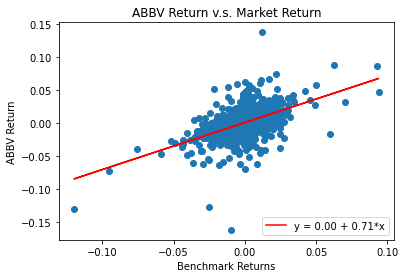



Filtered stock list
ABBV
ABT
BK
CAT
COST
CSCO
CVS
KMI
KO
LMT
MO
MRK
ORCL
PEP
PFE
PG
PM
QCOM
SBUX
SLB
SO
TGT
TXN
UNH
USB


In [139]:

test = StockFilter(volume_trading_days_filtered_list, StockAnalytics('^GSPC'));

# Filter by using stock_filter method:
result_list = test.stock_filter();
print('\n');
print('Filtered stock list')
for i in result_list:
    print(i);


## Part 3: Use Monte Carlo Simulation to Decide the Weighting for Each Selected Stock

In [141]:

class MonteCarloSimulation:
    def __init__(self,list_of_stocks):
        self.list_of_stocks = list_of_stocks;

    def simulation(self, stock, trials = 100000, interval=50, duration=1, r=0.045):
        # current stock price
        current_price = stock.get_info()['currentPrice'];

        # standard deviation of the stock based on implied volatility
        sigma = stock.get_weighted_implied_volatility();

        # dt is the length of each interval in terms of 1 year
        dt = duration / interval;
        # create a 2D array
        arr = np.zeros((interval + 1, trials));

        arr[0] = current_price;

        for i in range(1, interval + 1):
            arr[i] = arr[i-1] * np.exp((r - 0.5 * sigma ** 2) * dt + (sigma * np.sqrt(dt) * np.random.standard_normal(trials)));

        plt.hist(arr[-1], bins=50, ec='black');
        plt.xlabel('Simulated stock price in 1 year');
        plt.ylabel('Frequency');
        plt.title(stock.get_ticker() + ' Dynamically Simulated Stock Price By Geometric Stochastic Model')
        plt.show();

        average_terminal_price = np.round(np.mean(arr[-1]), 2);
        print('Average price after 1 year is $' + str(average_terminal_price));

        # Plot Dynamically Simulated Stock Price Path For First 10 simulation
        # To convince you our simulation works and give a good visualization of the simulation
        # we will plot the stock path for the first 10 simulation
        plt.plot(arr[:, : 10]);
        plt.title('Dynamically Simulated Stock Path of ' + stock.get_ticker());
        plt.xlabel('Time (interval)');
        plt.ylabel('Price of ' + stock.get_ticker());
        plt.show();

        average_return = np.round(average_terminal_price / current_price - 1, 4);

        return average_return;


    def simulate_all_stocks(self):
        list_of_tickers = map(lambda x:x.get_ticker(), self.list_of_stocks); 
        stocks_after_sim = pd.DataFrame(index=list_of_tickers);
        for i in self.list_of_stocks:
            data = self.simulation(i);
            stocks_after_sim.loc[i.get_ticker(),'Return'] = data;

        # sort stock list by rate of return
        stocks_after_sim = stocks_after_sim.sort_values(by=['Return'],ascending=False);
        return stocks_after_sim;

    def filter_after_simulation(self, stock_list, cutoff=25):
        # Check the length of the stock_list:
        if (len(stock_list.index) > cutoff):
            # determine cutoff value:
            cutoff_return = stock_list.iloc[cutoff]['Return'];
        else:
            return stock_list;

        return stock_list[stock_list['Return'] > cutoff_return];



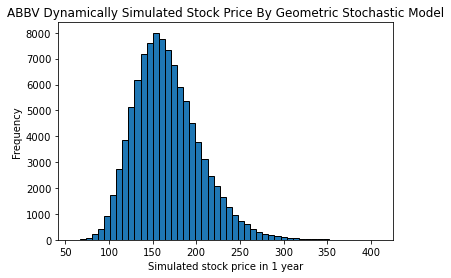

Average price after 1 year is $166.72


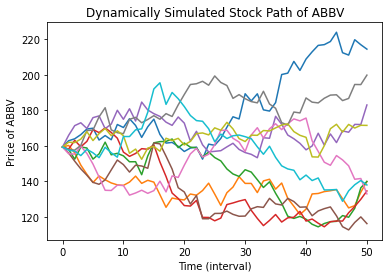

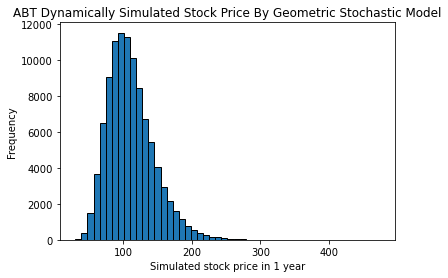

Average price after 1 year is $110.69


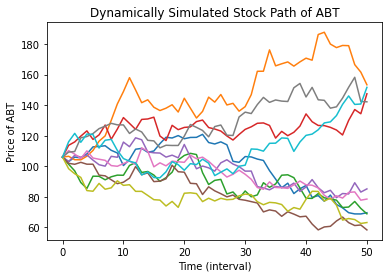

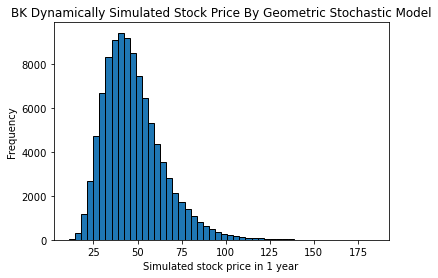

Average price after 1 year is $47.64


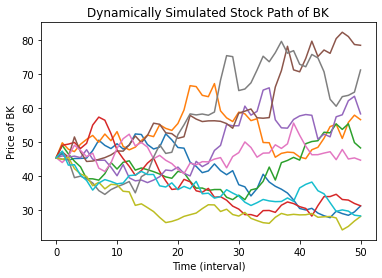

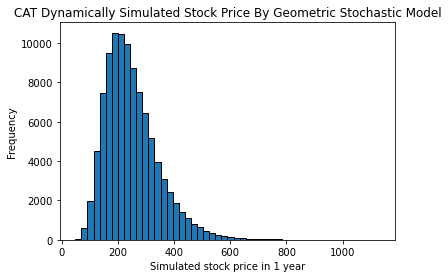

Average price after 1 year is $248.3


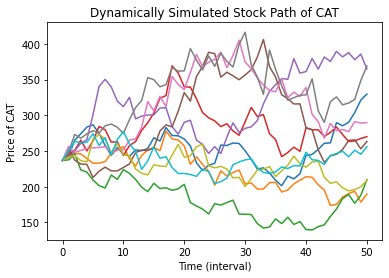

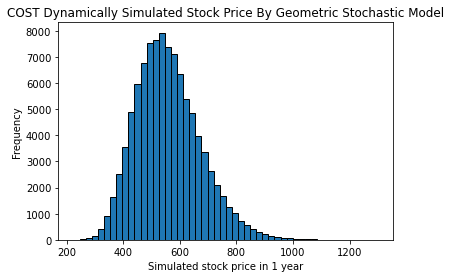

Average price after 1 year is $558.66


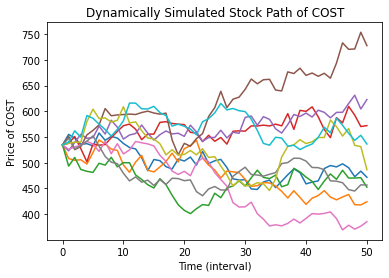

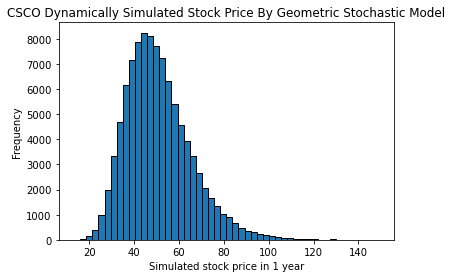

Average price after 1 year is $50.75


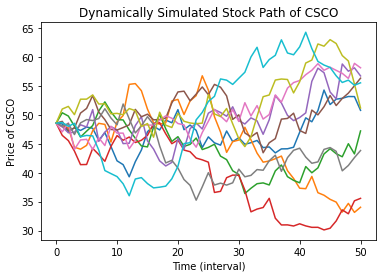

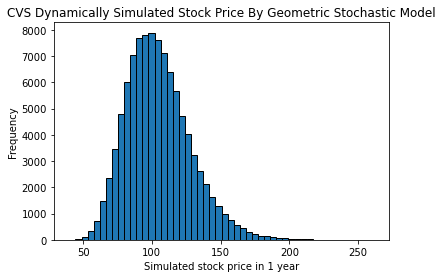

Average price after 1 year is $104.54


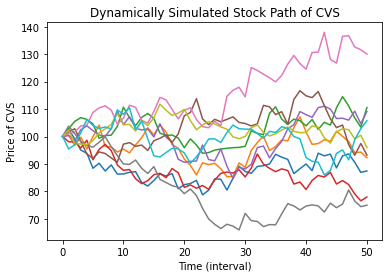

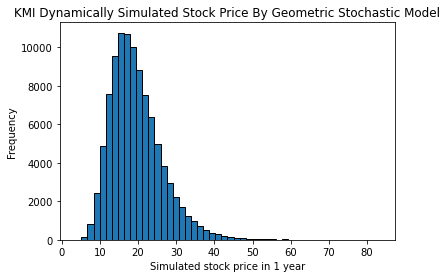

Average price after 1 year is $19.51


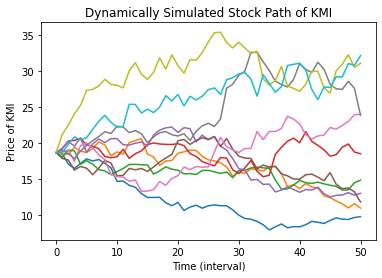

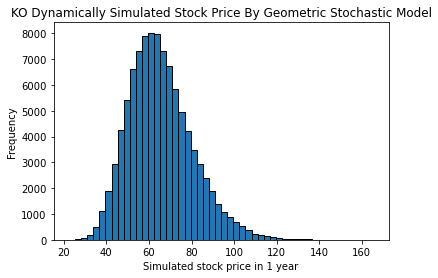

Average price after 1 year is $65.44


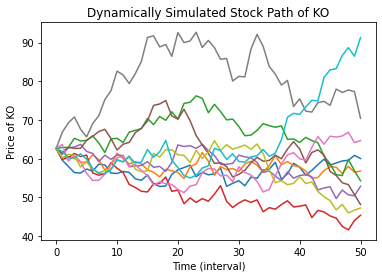

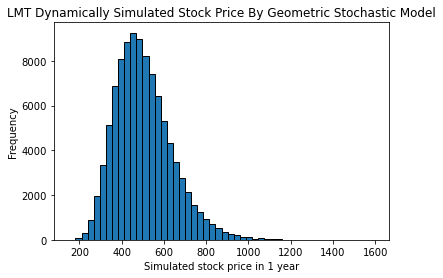

Average price after 1 year is $503.45


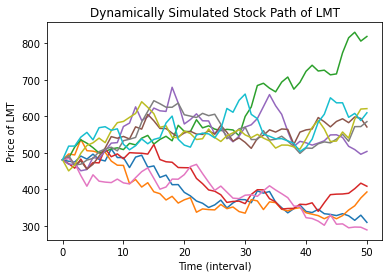

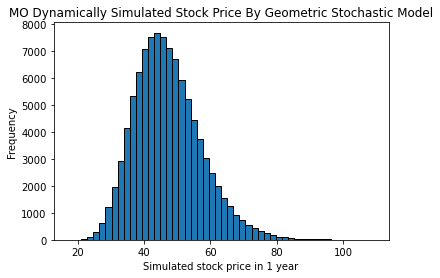

Average price after 1 year is $47.12


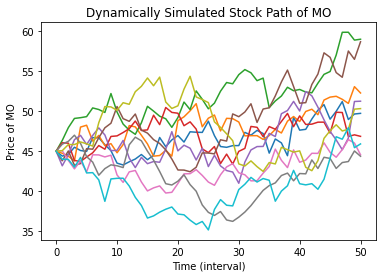

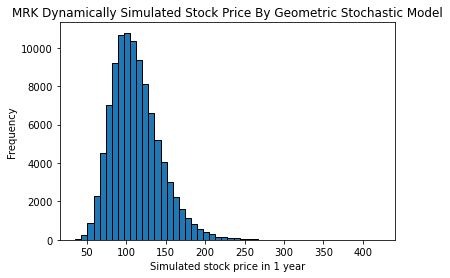

Average price after 1 year is $112.05


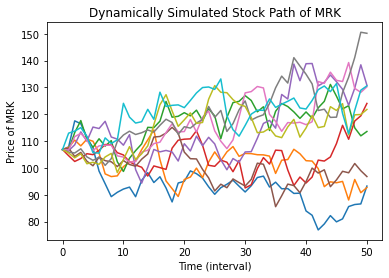

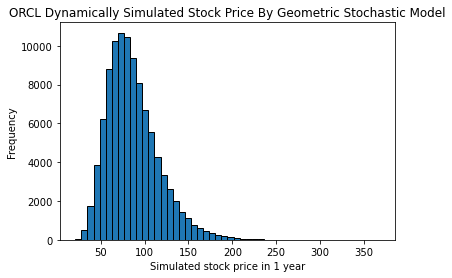

Average price after 1 year is $86.39


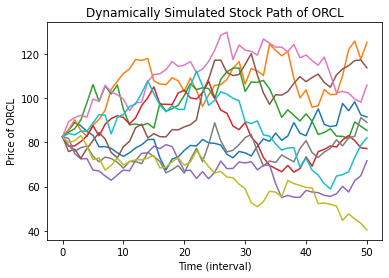

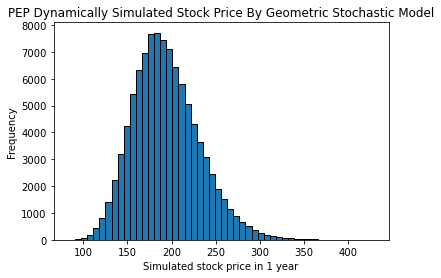

Average price after 1 year is $193.81


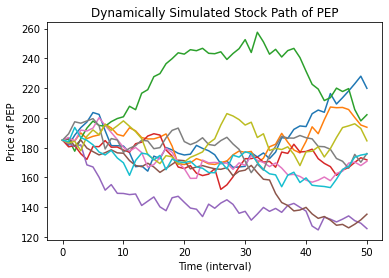

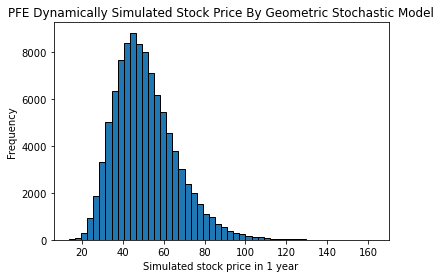

Average price after 1 year is $51.14


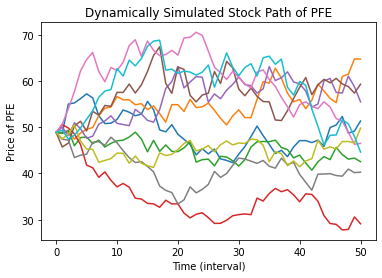

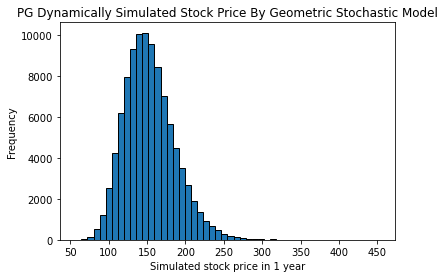

Average price after 1 year is $153.21


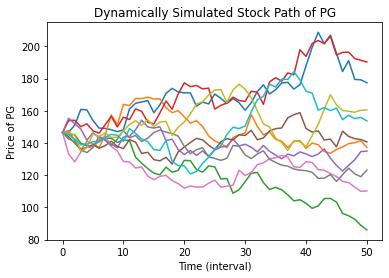

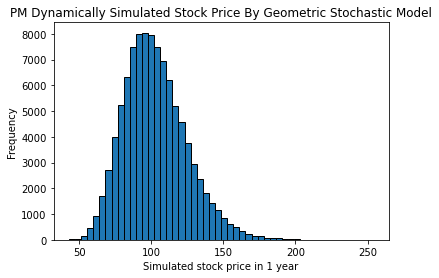

Average price after 1 year is $102.62


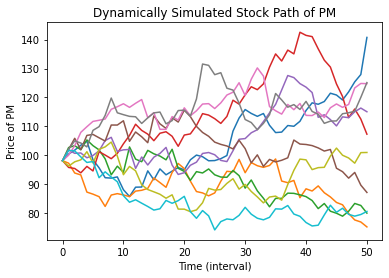

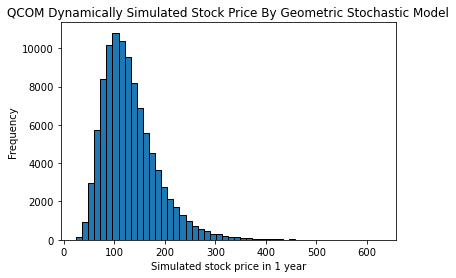

Average price after 1 year is $131.0


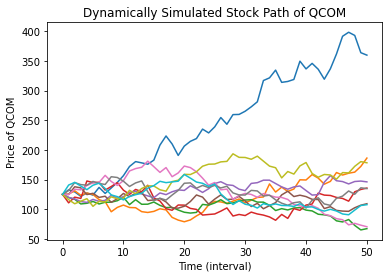

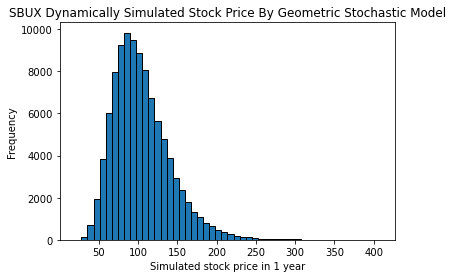

Average price after 1 year is $104.06


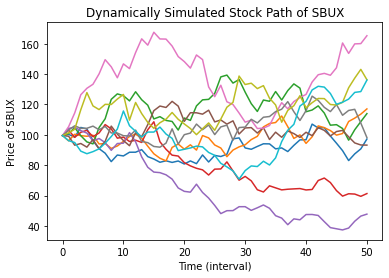

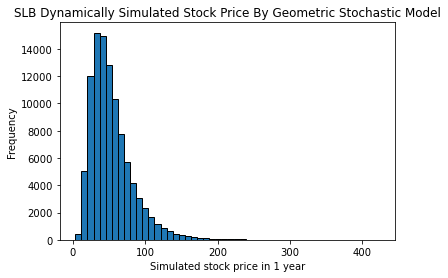

Average price after 1 year is $53.81


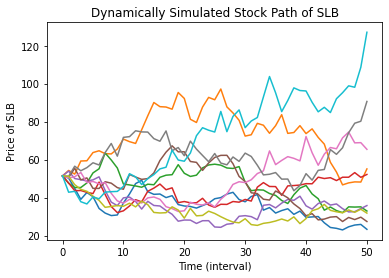

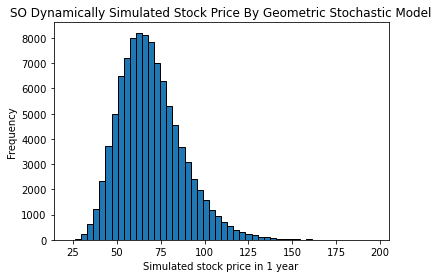

Average price after 1 year is $69.43


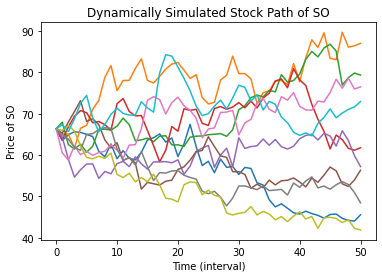

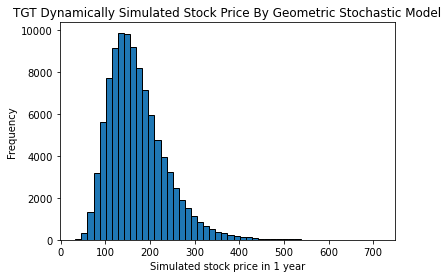

Average price after 1 year is $170.96


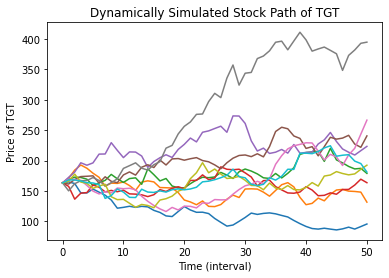

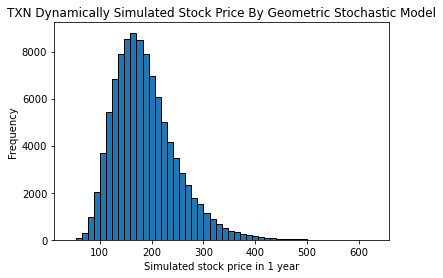

Average price after 1 year is $187.17


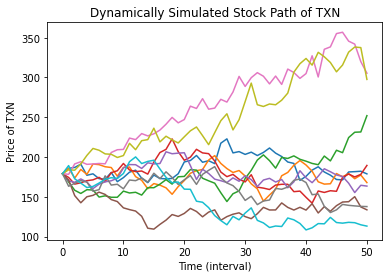

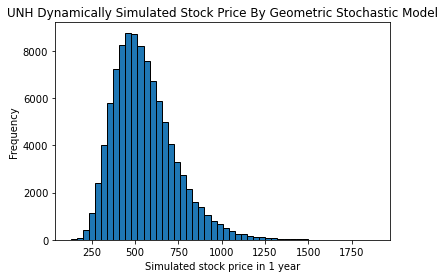

Average price after 1 year is $554.16


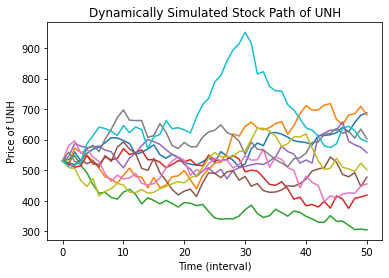

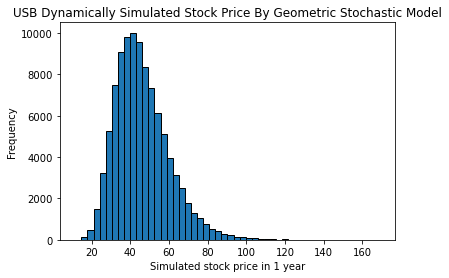

Average price after 1 year is $46.1


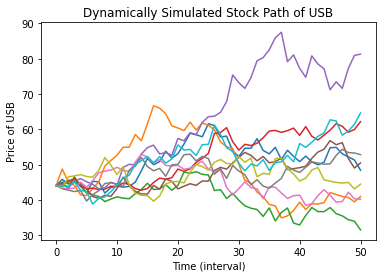

Simulation Result:
      Return
MRK   0.0490
CAT   0.0480
BK    0.0473
PEP   0.0472
PFE   0.0469
QCOM  0.0467
MO    0.0466
SLB   0.0465
LMT   0.0465
ORCL  0.0464
SO    0.0463
UNH   0.0462
TGT   0.0462
PG    0.0462
KMI   0.0461
PM    0.0460
ABBV  0.0460
TXN   0.0458
SBUX  0.0456
COST  0.0452
USB   0.0451
KO    0.0449
CSCO  0.0449
CVS   0.0448
ABT   0.0440


In [143]:
simulation = MonteCarloSimulation(result_list);
simulation_result_list = simulation.simulate_all_stocks();

# Present result list:
print('Simulation Result:')
print(simulation_result_list);


In [147]:
# We will filter 25 stocks based on the return ranking from simulation
final_filtered_stock_list =  simulation.filter_after_simulation(simulation_result_list);

# Present the final stock list (before weighting)
print(final_filtered_stock_list);


      Return
MRK   0.0490
CAT   0.0480
BK    0.0473
PEP   0.0472
PFE   0.0469
QCOM  0.0467
MO    0.0466
SLB   0.0465
LMT   0.0465
ORCL  0.0464
SO    0.0463
UNH   0.0462
TGT   0.0462
PG    0.0462
KMI   0.0461
PM    0.0460
ABBV  0.0460
TXN   0.0458
SBUX  0.0456
COST  0.0452
USB   0.0451
KO    0.0449
CSCO  0.0449
CVS   0.0448
ABT   0.0440


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.